In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import tensorflow_addons as tfa
import os
from PIL import Image
import pandas as pd
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

import ecoset
import categorization as cat
import utils

2022-08-11 15:20:42.953031: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Setup Ecoset models

In [2]:
# Load model
ecosetModel = ecoset.make_alex_net_v2(
    weights_path='./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89',
)
imagenetModel = ecoset.make_alex_net_v2(
    output_shape=1000, 
    weights_path='./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89',
)
ecosetModel.summary()

2022-08-11 15:20:44.348364: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-08-11 15:20:44.382566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 15:20:44.382843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 970 computeCapability: 5.2
coreClock: 1.253GHz coreCount: 13 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 208.91GiB/s
2022-08-11 15:20:44.382867: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-11 15:20:44.385861: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-11 15:20:44.385909: I tensorflow/stream_executor/plat

Weights from ./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89 loaded successfully.
Weights from ./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89 loaded successfully.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 54, 54, 64)        23296     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 26, 26, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 26, 26, 192)       307392    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 12, 12, 192)       0         
_______________________

In [3]:
ecosetModel = utils.make_output_model(ecosetModel)
imagenetModel = utils.make_output_model(imagenetModel)

In [4]:
# model = ecoset.make_vNet(
#     weights_path='./models/vNET/ecoset_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch79',
#     softmax=True,)
# model = Imagenet.make_vNet(
#     output_shape=1000, 
#     weights_path='./models/vNET/ILSVRC_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch79',
#     softmax=True,
# )
# model.summary()

# Setup Categorization Stimuli

In [4]:
trainCats, trainCounts = cat.build_categories_from_ecoset(
    './images/train', 
    includeSub=False,
    maxImgs=100
    )
testCats, testCounts = cat.build_categories_from_ecoset(
    './images/val+test',
    includeSub=False,
    maxImgs=100
)

trainImages = cat.get_images_from_cat(trainCats, preprocFun=ecoset.preprocess_alexnet)
testImages = cat.get_images_from_cat(testCats, preprocFun=ecoset.preprocess_alexnet)

In [5]:
birdTrainReps = ecosetModel.predict(trainImages['animal']['0085_bird'])[-1]
dogTrainReps = ecosetModel.predict(trainImages['animal']['0039_dog'])[-1]
carTrainReps = ecosetModel.predict(trainImages['vehicle']['0009_car'])[-1]
busTrainReps = ecosetModel.predict(trainImages['vehicle']['0089_bus'])[-1]

animalTrainReps = np.concatenate((birdTrainReps, dogTrainReps))
vehicleTrainReps = np.concatenate((carTrainReps, busTrainReps))

birdTestReps = ecosetModel.predict(testImages['animal']['0085_bird'])[-1]
dogTestReps = ecosetModel.predict(testImages['animal']['0039_dog'])[-1]
carTestReps = ecosetModel.predict(testImages['vehicle']['0009_car'])[-1]
busTestReps = ecosetModel.predict(testImages['vehicle']['0089_bus'])[-1]

animalTestReps = np.concatenate((birdTestReps, dogTestReps))
vehicleTestReps = np.concatenate((carTestReps, busTestReps))

2022-08-11 15:20:49.700587: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-11 15:20:49.717551: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3499995000 Hz
2022-08-11 15:20:49.835089: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-08-11 15:20:50.107456: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2022-08-11 15:20:50.338142: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-11 15:20:50.338167: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-08-11 15:20:50.338456: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-11 15:20:50.338503: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

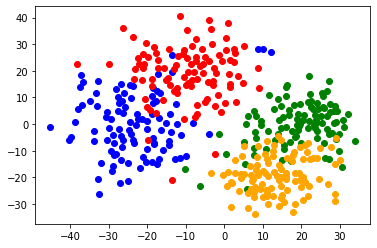

In [6]:
embedding = MDS(n_components=2)
solution = embedding.fit_transform(np.concatenate((birdTestReps, dogTestReps, carTestReps, busTestReps)))
plt.scatter(solution[0:100, 0], solution[0:100, 1], c='blue')
plt.scatter(solution[100:200, 0], solution[100:200, 1], c='red')
plt.scatter(solution[200:300, 0], solution[200:300, 1], c='green')
plt.scatter(solution[300:400, 0], solution[300:400, 1], c='orange')

# Category Verification Ecoset Model + GCM

In [19]:
# Reimplementation of task to confirmation task
maxExem = birdTrainReps.shape[0]
criterion = 25

verifData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])
for rep in birdTestReps:
    evidence = cat.get_evidence(rep, birdTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestReps:
    evidence = cat.get_evidence(rep, dogTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestReps:
    evidence = cat.get_evidence(rep, carTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestReps:
    evidence = cat.get_evidence(rep, busTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in animalTestReps:
    evidence = cat.get_evidence(rep, animalTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in vehicleTestReps:
    evidence = cat.get_evidence(rep, vehicleTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

In [20]:
# Group data basic on level and count responses
verifData.groupby(['level'])['resp'].value_counts()

level  resp
basic  yes     379
       no       21
super  yes     356
       no       44
Name: resp, dtype: int64

In [21]:
verifData.groupby(['level'])['rt'].mean()

level
basic    0.869541
super    0.895626
Name: rt, dtype: float64

# Category Choice Ecoset Model + GCM Sim

In [7]:
# Perform cat comparing against only the most similar category
withinCatEcosetData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])

for rep in birdTestReps:
    probs = cat.sim_prob(rep, birdTrainReps, dogTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    withinCatEcosetData = withinCatEcosetData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestReps:
    probs = cat.sim_prob(rep, dogTrainReps, birdTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetData = withinCatEcosetData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestReps:
    probs = cat.sim_prob(rep, carTrainReps, busTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetData = withinCatEcosetData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestReps:
    probs = cat.sim_prob(rep, busTrainReps, carTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetData = withinCatEcosetData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((birdTestReps, dogTestReps)):
    probs = cat.sim_prob(rep, [birdTrainReps, dogTrainReps], [carTrainReps, busTrainReps], cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetData = withinCatEcosetData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((carTrainReps, busTrainReps)):
    probs = cat.sim_prob(rep, [carTrainReps, busTrainReps], [birdTrainReps, dogTrainReps], cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetData = withinCatEcosetData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

In [8]:
# Group data basic on level and count responses
withinCatEcosetData.groupby(['level'])['resp'].value_counts()

level  resp
basic  yes     369
       no       31
super  yes     396
       no        4
Name: resp, dtype: int64

In [9]:
# Group data basic on level and get mean RTs
withinCatEcosetData.groupby(['level'])['rt'].mean()

level
basic    1.828109
super    1.549011
Name: rt, dtype: float64

In [11]:
# Perform cat comparing against all other categories
betweenCatEcosetData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])

for rep in birdTestReps:
    probs = cat.sim_prob(rep, birdTrainReps, [dogTrainReps, carTrainReps, busTrainReps], cat.gcm_sim, equalize=True)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    betweenCatEcosetData = betweenCatEcosetData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestReps:
    probs = cat.sim_prob(rep, dogTrainReps, [birdTrainReps, carTrainReps, busTrainReps], cat.gcm_sim, equalize=True)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    betweenCatEcosetData = betweenCatEcosetData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestReps:
    probs = cat.sim_prob(rep, carTrainReps, [busTrainReps, dogTrainReps, birdTrainReps], cat.gcm_sim, equalize=True)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    betweenCatEcosetData = betweenCatEcosetData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestReps:
    probs = cat.sim_prob(rep, busTrainReps, [carTrainReps, dogTrainReps, birdTrainReps], cat.gcm_sim, equalize=True)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    betweenCatEcosetData = betweenCatEcosetData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((birdTestReps, dogTestReps)):
    probs = cat.sim_prob(rep, [birdTrainReps, dogTrainReps], [carTrainReps, busTrainReps], cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    betweenCatEcosetData = betweenCatEcosetData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((carTrainReps, busTrainReps)):
    probs = cat.sim_prob(rep, [carTrainReps, busTrainReps], [birdTrainReps, dogTrainReps], cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    betweenCatEcosetData = betweenCatEcosetData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

In [12]:
# Group data basic on level and count responses
betweenCatEcosetData.groupby(['level'])['resp'].value_counts()

level  resp
basic  yes     398
       no        2
super  yes     396
       no        4
Name: resp, dtype: int64

In [13]:
# Group data basic on level and get mean RTs
betweenCatEcosetData.groupby(['level'])['rt'].mean()

level
basic    1.360280
super    1.218595
Name: rt, dtype: float64

# Category Choice Ecoset Model + Redist Sim

In [54]:
# Perform cat comparing against all other categories
withinCatEcosetRedistData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])
simFun = lambda x, y: cat.gcm_sim(x, y, p=1)

for rep in birdTestReps:
    birdEvidence = cat.redist_evidence(rep, birdTrainReps, dogTrainReps, simFun, dist_penalty=False)
    dogEvidence = cat.redist_evidence(rep, dogTrainReps, birdTrainReps, simFun, dist_penalty=False)
    birdProb = birdEvidence / (birdEvidence + dogEvidence)
    dogProb = dogEvidence / (birdEvidence + dogEvidence)
    resp, rt = cat.LBA_deterministic(birdProb, dogProb)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    withinCatEcosetRedistData = withinCatEcosetRedistData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestReps:
    birdEvidence = cat.redist_evidence(rep, birdTrainReps, dogTrainReps, simFun, dist_penalty=False)
    dogEvidence = cat.redist_evidence(rep, dogTrainReps, birdTrainReps, simFun, dist_penalty=False)
    birdProb = birdEvidence / (birdEvidence + dogEvidence)
    dogProb = dogEvidence / (birdEvidence + dogEvidence)

    resp, rt = cat.LBA_deterministic(dogProb, birdProb)
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetRedistData = withinCatEcosetRedistData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestReps:
    carEvidence = cat.redist_evidence(rep, carTrainReps, busTrainReps, simFun, dist_penalty=False)
    busEvidence = cat.redist_evidence(rep, busTrainReps, carTrainReps, simFun, dist_penalty=False)
    carProb = carEvidence / (carEvidence + busEvidence)
    busProb = busEvidence / (carEvidence + busEvidence)

    resp, rt = cat.LBA_deterministic(carProb, busProb)
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetRedistData = withinCatEcosetRedistData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestReps:
    carEvidence = cat.redist_evidence(rep, carTrainReps, busTrainReps, simFun, dist_penalty=False)
    busEvidence = cat.redist_evidence(rep, busTrainReps, carTrainReps, simFun, dist_penalty=False)
    carProb = carEvidence / (carEvidence + busEvidence)
    busProb = busEvidence / (carEvidence + busEvidence)

    resp, rt = cat.LBA_deterministic(busProb, carProb)
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetRedistData = withinCatEcosetRedistData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((birdTestReps, dogTestReps)):
    animalEvidence = cat.redist_evidence(rep, animalTrainReps, vehicleTrainReps, simFun, dist_penalty=False)
    vehicleEvidence = cat.redist_evidence(rep, vehicleTrainReps, animalTrainReps, simFun, dist_penalty=False)
    animalProb = animalEvidence / (animalEvidence + vehicleEvidence)
    vehicleProb = vehicleEvidence / (animalEvidence + vehicleEvidence)

    resp, rt = cat.LBA_deterministic(animalProb, vehicleProb)
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetRedistData = withinCatEcosetRedistData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((carTrainReps, busTrainReps)):
    animalEvidence = cat.redist_evidence(rep, animalTrainReps, vehicleTrainReps, simFun, dist_penalty=False)
    vehicleEvidence = cat.redist_evidence(rep, vehicleTrainReps, animalTrainReps, simFun, dist_penalty=False)
    animalProb = animalEvidence / (animalEvidence + vehicleEvidence)
    vehicleProb = vehicleEvidence / (animalEvidence + vehicleEvidence)

    resp, rt = cat.LBA_deterministic(vehicleProb, animalProb)
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetRedistData = withinCatEcosetRedistData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

In [55]:
# Group data basic on level and count responses
withinCatEcosetRedistData.groupby(['level'])['resp'].value_counts()

level  resp
basic  yes     375
       no       25
super  yes     392
       no        8
Name: resp, dtype: int64

In [56]:
# Group data basic on level and get mean RTs
withinCatEcosetRedistData.groupby(['level'])['rt'].mean()

level
basic    1.908248
super    1.848217
Name: rt, dtype: float64

# Category Choice Ecoset Model + Prod Sim

In [14]:
# Perform cat comparing against only the most similar category
withinCatEcosetProdData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])

for rep in birdTestReps:
    probs = cat.sim_prob(rep, birdTrainReps, dogTrainReps, cat.prod_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    withinCatEcosetProdData = withinCatEcosetProdData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestReps:
    probs = cat.sim_prob(rep, dogTrainReps, birdTrainReps, cat.prod_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetProdData = withinCatEcosetProdData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestReps:
    probs = cat.sim_prob(rep, carTrainReps, busTrainReps, cat.prod_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetProdData = withinCatEcosetProdData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestReps:
    probs = cat.sim_prob(rep, busTrainReps, carTrainReps, cat.prod_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetProdData = withinCatEcosetProdData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((birdTestReps, dogTestReps)):
    probs = cat.sim_prob(rep, [birdTrainReps, dogTrainReps], [carTrainReps, busTrainReps], cat.prod_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetProdData = withinCatEcosetProdData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((carTrainReps, busTrainReps)):
    probs = cat.sim_prob(rep, [carTrainReps, busTrainReps], [birdTrainReps, dogTrainReps], cat.prod_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetProdData = withinCatEcosetProdData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

In [15]:
# Group data basic on level and count responses
withinCatEcosetProdData.groupby(['level'])['resp'].value_counts()

level  resp
basic  yes     361
       no       39
super  yes     390
       no       10
Name: resp, dtype: int64

In [16]:
# Group data basic on level and get mean RTs
withinCatEcosetProdData.groupby(['level'])['rt'].mean()

level
basic    1.858523
super    1.585520
Name: rt, dtype: float64

# Category Choice VGG16 Model + GCM Sim

In [2]:
model = tf.keras.applications.vgg16.VGG16(include_top=True)

# Get output from penultimate layer
model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

model.summary()

2022-07-05 21:04:02.931333: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-05 21:04:02.964976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 21:04:02.965526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 970 computeCapability: 5.2
coreClock: 1.253GHz coreCount: 13 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 208.91GiB/s
2022-07-05 21:04:02.965543: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-05 21:04:02.968642: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-05 21:04:02.968685: I tensorflow/stream_executor/plat

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

2022-07-05 21:04:04.472638: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.


In [26]:
trainCats, trainCounts = cat.build_categories_from_ecoset(
    './images/train', 
    includeSub=False,
    maxImgs=100
    )
testCats, testCounts = cat.build_categories_from_ecoset(
    './images/val+test',
    includeSub=False,
    maxImgs=100
)

def vggPreprocess(img):
    if isinstance(img, Image.Image):
        img = img.convert("RGB")
    img = np.array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (224, 224))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img
    
trainImages = cat.get_images_from_cat(trainCats, preprocFun = vggPreprocess)
testImages = cat.get_images_from_cat(testCats, preprocFun = vggPreprocess)

In [24]:
image = Image.open(trainCats['animal']['0085_bird'][0])
image = image.convert('RGB')
image = np.array(image)
image = tf.keras.preprocessing.image.smart_resize(image, (224, 224))
image = tf.keras.applications.vgg16.preprocess_input(image)
image = np.expand_dims(image, axis=0)

In [32]:
birdTrainReps = model.predict(trainImages['animal']['0085_bird'])
dogTrainReps = model.predict(trainImages['animal']['0039_dog'])
carTrainReps = model.predict(trainImages['vehicle']['0009_car'])
busTrainReps = model.predict(trainImages['vehicle']['0089_bus'])

birdTestReps = model.predict(testImages['animal']['0085_bird'])
dogTestReps = model.predict(testImages['animal']['0039_dog'])
carTestReps = model.predict(testImages['vehicle']['0009_car'])
busTestReps = model.predict(testImages['vehicle']['0089_bus'])

In [36]:
# Perform cat comparing against only the most similar category
withinCatVGGData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])

for rep in birdTestReps:
    probs = cat.sim_prob(rep, birdTrainReps, dogTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    withinCatVGGData = withinCatVGGData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestReps:
    probs = cat.sim_prob(rep, dogTrainReps, birdTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatVGGData = withinCatVGGData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestReps:
    probs = cat.sim_prob(rep, carTrainReps, busTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatVGGData = withinCatVGGData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestReps:
    probs = cat.sim_prob(rep, busTrainReps, carTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatVGGData = withinCatVGGData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((birdTestReps, dogTestReps)):
    probs = cat.sim_prob(rep, [birdTrainReps, dogTrainReps], [carTrainReps, busTrainReps], cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatVGGData = withinCatVGGData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((carTrainReps, busTrainReps)):
    probs = cat.sim_prob(rep, [carTrainReps, busTrainReps], [birdTrainReps, dogTrainReps], cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatVGGData = withinCatVGGData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

In [37]:
# Group data basic on level and count responses
withinCatVGGData.groupby(['level'])['resp'].value_counts()

level  resp
basic  yes     381
       no       19
super  yes     267
       no      133
Name: resp, dtype: int64

In [38]:
withinCatVGGData.groupby(['level'])['rt'].mean()

level
basic    1.602942
super    1.588251
Name: rt, dtype: float64

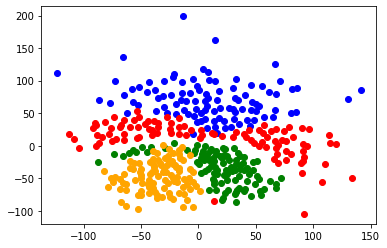

In [39]:
embedding = MDS(n_components=2)
solution = embedding.fit_transform(np.concatenate((birdTestReps, dogTestReps, carTestReps, busTestReps)))
plt.scatter(solution[0:100, 0], solution[0:100, 1], c='blue')
plt.scatter(solution[100:200, 0], solution[100:200, 1], c='red')
plt.scatter(solution[200:300, 0], solution[200:300, 1], c='green')
plt.scatter(solution[300:400, 0], solution[300:400, 1], c='orange')

# Sandbox

In [7]:
# Reimplementation of task to confirmation task
maxExem = birdTrainReps.shape[0]
criterion = 25

verifData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])
for rep in birdTestReps:
    evidence = cat.get_evidence(rep, birdTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.3)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestReps:
    evidence = cat.get_evidence(rep, dogTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.3)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestReps:
    evidence = cat.get_evidence(rep, carTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.3)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestReps:
    evidence = cat.get_evidence(rep, busTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.3)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in animalTestReps:
    evidence = cat.get_evidence(rep, animalTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.3)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in vehicleTestReps:
    evidence = cat.get_evidence(rep, vehicleTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.3)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)


In [8]:
# Group data basic on level and count responses
verifData.groupby(['level'])['resp'].value_counts()

level  resp
basic  yes     379
       no       21
super  yes     354
       no       46
Name: resp, dtype: int64

In [9]:
verifData.groupby(['level'])['rt'].mean()

level
basic    0.521725
super    0.537252
Name: rt, dtype: float64